In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'unsw-nb15:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F111554%2F267091%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T041918Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc52fd3118204d77e26c31666afec398fc53e85ba5ab5fc818f7a8d68470aba30e8c769d0463f372e04b55c782e0658e2a99a253af806cea4e0646c96910ba9f171ccb3939cdbaa0e9e220df896c05c9ad15262ac0fdaacc96bca67d4fee4e55db5d0e831d2fcf95abb4ab7353351d3e5bab170e435d9a740bdb710383b17b34a6f45405d4f6e7965dc08db6f25831f94a5bb845e97d3dc0902989d1ce526353b60dcb3e547fa6c9f7047d31a04cd11091f86afb129f0a7d4b517eb9bda922fb2792bc87466e197df13883f27dfd14cf8f677def877a7cac9ed70defa7d9f5e3c21cdcb79403a0865a85b1d68d5d639c2cafa1a718342f72c8b639c99db4b4eca'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

!pip install keras_tuner

print('Data source import complete.')


[==================================================] 156257637 bytes downloaded
Downloaded and uncompressed: unsw-nb15
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00
Data source import complete.


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='1'></a>
# 1 | Importing Required Libraries & DataSource

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/fTDmwnkQ/Miaka.png); background-size: 100% auto;"></div>


In [2]:
# Libraries for Data Manipulation
import pandas as pd
import numpy as np

import gc

# Libraries for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from scipy.stats import skew
sns.set(style="white", font_scale=1.5)
sns.set(rc={"axes.facecolor":"#FFFAF0", "figure.facecolor":"#FFFAF0"})
sns.set_context("poster", font_scale=.7)
import matplotlib.ticker as ticker

# Libraries to Handle Warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries for Statistical Analysis
from scipy import stats
from scipy.stats import chi2, chi2_contingency

# Setting Display Options
pd.set_option("display.max.columns", None)

# Machine Learning Algorithms
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import SGD
import keras_tuner
import keras


# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,silhouette_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# Data Source
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='1.1'></a>
# Load and Inspect Dataset

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/fTDmwnkQ/Miaka.png); background-size: 100% auto;"></div>


In [3]:
testing_set = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')
training_set = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
LIST_EVENTS = pd.read_csv('/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv')
NB15_1 = pd.read_csv('/kaggle/input/unsw-nb15/UNSW-NB15_1.csv')
NB15_2 = pd.read_csv('/kaggle/input/unsw-nb15/UNSW-NB15_2.csv')
NB15_3 = pd.read_csv('/kaggle/input/unsw-nb15/UNSW-NB15_3.csv')
NB15_4 = pd.read_csv('/kaggle/input/unsw-nb15/UNSW-NB15_4.csv')
NB15_features = pd.read_csv('/kaggle/input/unsw-nb15/NUSW-NB15_features.csv', encoding='cp1252')

In [4]:
testing_set.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [5]:
training_set.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [6]:
LIST_EVENTS.head()

,Attack category,Attack subcategory,Number of events
0,normal,NaN,2218761
1,Fuzzers,FTP,558
2,Fuzzers,HTTP,1497
3,Fuzzers,RIP,3550
4,Fuzzers,SMB,5245


In [7]:
NB15_1.head()

,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0.1,dns,500473.9375,621800.9375,2,2.1,0.2,0.3,0.4,0.5,66,82,0.6,0.7,0.8,0.9,1421927414,1421927414.1,0.017,0.013,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,3,7,1,3.1,1.1,1.2,1.3,Unnamed: 47,0.18
0,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.891010,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,NaN,0
1,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0,0,0,12,8,1,2,2,1,1,NaN,0
2,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0,0,0,6,9,1,1,1,1,1,NaN,0
3,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0,0,0,7,9,1,1,1,1,1,NaN,0
4,59.166.0.0,32119,149.171.126.9,111,udp,CON,0.078339,568,312,31,29,0,0,-,43503.23438,23896.14258,4,4,0,0,0,0,142,78,0,0,29.682221,34.370340,1421927414,1421927414,21.003,24.315000,0.0,0.0,0.0,0,0,0,0,0,2,4,2,3,1,1,2,NaN,0


In [8]:
NB15_2.head()

,59.166.0.0,6055,149.171.126.5,54145,tcp,FIN,0.072974,4238,60788,31,29,7,30,-,458245.4375,6571546.5,72,72.1,255,255.1,1003293149,1003585034,59,844,0,0.1,62.04531,61.899776,1421955842,1421955842.1,1.02269,0.997042,0.002317,0.002173,0.000144,0.2,0.3,0.4,0.5,0.6,13,13.1,6,7.1,1,1.1,2,Unnamed: 47,0.7
0,59.166.0.0,7832,149.171.126.3,5607,tcp,FIN,0.144951,5174,91072,31,29,7,39,-,2.824127e+05,4.971776e+06,90,92,255,255,3152877672,1047439924,57,990,0,0,98.166675,97.062913,1421955842,1421955842,1.624562,1.587374,0.000665,0.000497,0.000168,0,0,0.0,0.0,0,13,13,6,7,1,1,2,NaN,0
1,59.166.0.8,11397,149.171.126.6,21,tcp,FIN,0.116107,2934,3742,31,29,11,15,ftp,1.982998e+05,2.530769e+05,52,54,255,255,3208685093,3215278370,56,69,0,0,194.564141,4.796288,1421955842,1421955842,2.314660,2.149906,0.002342,0.002151,0.000191,0,0,0.0,1.0,1,1,2,7,5,1,1,4,NaN,0
2,59.166.0.0,3804,149.171.126.3,53,udp,CON,0.000986,146,178,31,29,0,0,-,5.922921e+05,7.221095e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421955842,1421955842,0.011000,0.009000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,13,13,6,7,1,1,2,NaN,0
3,59.166.0.8,14339,149.171.126.6,14724,tcp,FIN,0.038480,8928,320,31,29,4,1,-,1.723701e+06,5.550936e+04,14,6,255,255,1063301791,1113098865,638,53,0,0,245.278645,11.454426,1421955842,1421955842,2.960000,6.054000,0.008268,0.008075,0.000193,0,0,0.0,0.0,0,8,20,7,5,1,1,4,NaN,0
4,59.166.0.8,39094,149.171.126.3,53,udp,CON,0.001026,130,162,31,29,0,0,-,5.068226e+05,6.315789e+05,2,2,0,0,0,0,65,81,0,0,0.000000,0.000000,1421955842,1421955842,0.010000,0.002000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,8,13,6,5,1,1,1,NaN,0


In [9]:
NB15_3.head()

,59.166.0.1,18247,149.171.126.4,7662,tcp,FIN,0.119596,4550,68342,31,29,7,33,-,300478.2813,4514398.5,78,80,255,255.1,1818376620,1818657356,58,854,0,0.1,87.137592,85.643619,1424231129,1424231129.1,1.549156,1.50719,0.000644,0.000521,0.000123,0.2,0.3,Unnamed: 37,Unnamed: 38,,6,2,2.1,5,1,1.1,2.2,Unnamed: 47,0.4
0,59.166.0.3,54771,149.171.126.2,27709,tcp,FIN,0.650574,8928,320,31,29,4,1,ftp-data,1.019530e+05,3.283254e+03,14,6,255,255,4075447467,3777413974,638,53,0,0,4045.664812,162.187656,1424231129,1424231129,50.044153,129.990797,0.000616,0.000495,0.000121,0,0,NaN,NaN,,3,5,2,4,1,1,4,NaN,0
1,59.166.0.8,13289,149.171.126.9,5190,tcp,FIN,0.007980,2158,2464,31,29,6,6,-,2.074185e+06,2.367920e+06,24,24,255,255,1638377249,1638673555,90,103,0,0,23.013883,0.487342,1424231129,1424231129,0.347545,0.322913,0.000668,0.000544,0.000124,0,0,NaN,NaN,,3,5,1,1,1,1,3,NaN,0
2,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,0,0,0,dns,2.112000e+08,0.000000e+00,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,1424231129,1424231129,0.005000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,19,19,19,19,19,19,19,NaN,0
3,149.171.126.18,1043,175.45.176.3,53,udp,INT,0.000005,264,0,60,0,0,0,dns,2.112000e+08,0.000000e+00,2,0,0,0,0,0,132,0,0,0,0.000000,0.000000,1424231129,1424231129,0.005000,0.000000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,19,19,19,19,19,19,19,NaN,0
4,59.166.0.3,10275,149.171.126.0,25,tcp,FIN,0.486578,37462,3380,31,29,18,8,smtp,6.040882e+05,5.425646e+04,52,42,255,255,1518379503,3670369209,720,80,0,0,768.061343,24.935787,1424231128,1424231129,9.533961,11.645000,0.016012,0.009132,0.006880,0,0,NaN,NaN,,3,2,3,4,2,1,2,NaN,0


In [10]:
NB15_4.head()

,59.166.0.9,7045,149.171.126.7,25,tcp,FIN,0.201886,37552,3380,31,29,18,8,smtp,1459437.5,130766.8672,52,42,255,255.1,1422136554,3572668484,722,80,0,0.1,456.043567,15.530109,1424250009,1424250009.1,3.943843,4.912488,0.00059,0.000473,0.000117,0.2,0.3,Unnamed: 37,Unnamed: 38,,2,2.1,7,4,1,1.1,3,Unnamed: 47,0.4
0,59.166.0.9,9685,149.171.126.2,80,tcp,FIN,5.864748,19410,1087890,31,29,2,370,http,2.640454e+04,1.481983e+06,364,746,255,255,389619597,394688654,53,1458,1,0,1031.366423,690.219581,1424250003,1424250009,16.155447,7.871279,0.000771,0.000638,0.000133,0,0,1.0,NaN,,3,1,4,4,1,1,1,NaN,0
1,59.166.0.2,1421,149.171.126.4,53,udp,CON,0.001391,146,178,31,29,0,0,dns,4.198418e+05,5.118620e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.002000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,3,5,2,7,1,1,4,NaN,0
2,59.166.0.2,21553,149.171.126.2,25,tcp,FIN,0.053948,37812,3380,31,29,19,8,smtp,5.503374e+06,4.893601e+05,54,42,255,255,4047523379,1903327524,700,80,0,0,65.909688,3.155258,1424250009,1424250009,1.011547,1.302561,0.000674,0.000540,0.000134,0,0,NaN,NaN,,1,1,4,7,1,1,3,NaN,0
3,59.166.0.8,45212,149.171.126.4,53,udp,CON,0.000953,146,178,31,29,0,0,dns,6.128017e+05,7.471144e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424250009,1424250009,0.009000,0.004000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,2,5,2,1,1,1,2,NaN,0
4,59.166.0.0,59922,149.171.126.8,6881,tcp,FIN,8.633186,25056,1094788,31,29,38,390,-,2.316642e+04,1.013311e+06,446,858,255,255,497111133,526810925,56,1276,0,0,7751.702640,5572.343447,1424250000,1424250009,19.443407,10.084887,0.000654,0.000516,0.000138,0,0,NaN,NaN,,9,7,2,3,2,1,6,NaN,0


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='1.2'></a>
# Understanding About features

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/fTDmwnkQ/Miaka.png); background-size: 100% auto;"></div>


In [11]:
NB15_features

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='1.3'></a>
# Concating the Data

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/fTDmwnkQ/Miaka.png); background-size: 100% auto;"></div>


In [12]:
NB15_1.columns = NB15_features['Name']
NB15_2.columns = NB15_features['Name']
NB15_3.columns = NB15_features['Name']
NB15_4.columns = NB15_features['Name']

In [13]:
train_df = pd.concat([NB15_1, NB15_2, NB15_3, NB15_4], ignore_index=True)

In [14]:
# Shuffle the data points in train_df
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
train_df

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,175.45.176.3,57672,149.171.126.15,3260,tcp,CON,0.285356,986,86,62,252,2,1,-,2.304490e+04,1.205512e+03,6,2,255,255,761934099,3893365633,164,43,0,0,3661.562382,0.000000,1424224369,1424224369,57.071200,0.002000,0.257434,0.182930,0.074504,0,3,NaN,NaN,,10,8,4,5,3,1,7,NaN,0
1,59.166.0.8,38052,149.171.126.9,6881,tcp,FIN,0.314311,1540,1644,31,29,4,4,-,3.675341e+04,3.952773e+04,16,18,255,255,734569334,2907227880,96,91,0,0,1385.623880,35.106383,1424252728,1424252728,20.925067,18.459766,0.000596,0.000494,0.000102,0,0,NaN,NaN,,14,6,8,12,5,1,6,NaN,0
2,59.166.0.0,42911,149.171.126.2,38558,udp,CON,0.301180,536,304,31,29,0,0,-,1.067800e+04,6.056179e+03,4,4,0,0,0,0,134,76,0,0,116.927883,123.543578,1421934312,1421934313,82.683000,87.363000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,9,16,7,6,1,1,3,NaN,0
3,175.45.176.1,47439,149.171.126.14,53,udp,INT,0.000009,114,0,254,0,0,0,dns,5.066666e+07,0.000000e+00,2,0,0,0,0,0,57,0,0,0,0.000000,0.000000,1424252582,1424252582,0.009000,0.000000,0.000000,0.000000,0.000000,0,2,NaN,NaN,,33,33,17,17,17,17,33,Generic,1
4,59.166.0.5,61544,149.171.126.6,53,udp,CON,0.001079,146,178,31,29,0,0,dns,5.412419e+05,6.598702e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424243836,1424243836,0.009000,0.007000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,2,2,5,4,1,1,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540038,59.166.0.8,34415,149.171.126.0,5190,tcp,FIN,0.008119,1920,4312,31,29,6,6,-,1.806134e+06,4.072423e+06,22,24,255,255,2097393639,4247267529,87,180,0,0,24.265009,21.052982,1421931570,1421931570,0.369952,0.328696,0.000680,0.000548,0.000132,0,0,0.0,0.0,0,3,10,4,1,1,1,1,NaN,0
2540039,59.166.0.8,56352,149.171.126.2,53,udp,CON,0.001047,130,162,31,29,0,0,dns,4.966571e+05,6.189111e+05,2,2,0,0,0,0,65,81,0,0,0.000000,0.000000,1424238783,1424238783,0.009000,0.007000,0.000000,0.000000,0.000000,0,0,NaN,NaN,,1,1,2,6,1,1,1,NaN,0
2540040,59.166.0.9,25527,149.171.126.4,6881,tcp,FIN,0.013106,1540,1644,31,29,4,4,-,8.814284e+05,9.479628e+05,16,18,255,255,1097293365,3252878568,96,91,0,0,59.343892,1.359939,1424257156,1424257156,0.852800,0.744353,0.000564,0.000449,0.000115,0,0,NaN,NaN,,12,11,8,9,6,1,6,NaN,0
2540041,175.45.176.1,47439,149.171.126.14,53,udp,INT,0.000003,114,0,254,0,0,0,dns,1.520000e+08,0.000000e+00,2,0,0,0,0,0,57,0,0,0,0.000000,0.000000,1424253397,1424253397,0.003000,0.000000,0.000000,0.000000,0.000000,0,2,NaN,NaN,,37,37,26,26,26,13,37,Generic,1


<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='2'></a>
# 2 | Data Analysis and Basic preprocessing

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/fTDmwnkQ/Miaka.png); background-size: 100% auto;"></div>


<a id='2.1'></a>
## **1. Computing Dimension of Dataset**

In [16]:
print("dataset shape: ",train_df.shape)

dataset shape:  (2540043, 49)


<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* There is total **2540043 records** and **49 columns** availabe in the train_dataset.

<a id='2.2'></a>
## **2. Statistical Summary of Dataset**

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540043 entries, 0 to 2540042
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  Sload             float64
 15  Dload             float64
 16  Spkts             int64  
 17  Dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  Sjit          

In [18]:
# Identify the data types of columns
column_data_types = train_df.dtypes

# Count the numerical and categorical columns
numerical_count = 0
categorical_count = 0

for column_name, data_type in column_data_types.items():
    if np.issubdtype(data_type, np.number):
        numerical_count += 1
    else:
        categorical_count += 1

# Print the counts
print(f"There are {numerical_count} Numerical Columns in dataset")
print(f"There are {categorical_count} Categorical Columns in dataset")

There are 40 Numerical Columns in dataset
There are 9 Categorical Columns in dataset


<a id='2.3'></a>
## 3. **Checking if There's Any Duplicate Records.**

In [19]:
print("Duplicates in train_df: ",train_df.duplicated().sum())

Duplicates in train_df:  480626


In [20]:
train_df = train_df.drop_duplicates()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* There are 480626 duplicate records present in the dataset.

<a id='2.4'></a>
## 4. **Computing Total No. of Missing Values and the Percentage of Missing Values**

In [21]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
Name,,
srcip,0,0.00
sport,0,0.00
dstip,0,0.00
dsport,0,0.00
proto,0,0.00
state,0,0.00
dur,0,0.00
sbytes,0,0.00
dbytes,0,0.00


## **Handling Null values here because it create wrong inference in EDA**

In [22]:
# NaN values implies that no attack are there for that particular row data, Replace NaN values in the 'attack_cat' column with 'not attacked'
train_df['attack_cat'].fillna('normal',inplace = True)
train_df['attack_cat'] = train_df['attack_cat'].apply(lambda x: x.strip().lower())

# missing values imply that there were no flows with HTTP methods in certain instances so we will replace the NAN with 0
train_df['ct_flw_http_mthd'].fillna(0, inplace=True)

# is_ftp_login is of type binary that mean it takes 1(user has loged in) or 0 (or not) so the best approch is to replace nan with 0
train_df['is_ftp_login'].fillna(0, inplace=True)

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* ct_flw_http_mthd,is_ftp_login and attack_cat of the Attribute are having Missing Values we handle it later.  

<a id='2.5'></a>
## **5. Performing Descriptive Analysis**

In [23]:
round(train_df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Name,,,,,,,,
dur,2059417.0,6.500000e-01,1.104000e+01,0.000000e+00,0.000000e+00,3.000000e-02,3.300000e-01,8.786640e+03
sbytes,2059417.0,5.098050e+03,6.213721e+04,0.000000e+00,4.240000e+02,1.684000e+03,3.728000e+03,1.435577e+07
dbytes,2059417.0,4.192614e+04,1.698574e+05,0.000000e+00,3.040000e+02,3.080000e+03,1.991800e+04,1.465753e+07
sttl,2059417.0,4.360000e+01,5.052000e+01,0.000000e+00,3.100000e+01,3.100000e+01,3.100000e+01,2.550000e+02
dttl,2059417.0,3.650000e+01,4.370000e+01,0.000000e+00,2.900000e+01,2.900000e+01,2.900000e+01,2.540000e+02
sloss,2059417.0,6.110000e+00,2.458000e+01,0.000000e+00,0.000000e+00,4.000000e+00,7.000000e+00,5.319000e+03
dloss,2059417.0,1.893000e+01,5.953000e+01,0.000000e+00,0.000000e+00,5.000000e+00,1.500000e+01,5.507000e+03
Sload,2059417.0,9.066831e+06,7.363605e+07,0.000000e+00,8.077723e+04,5.407408e+05,1.095758e+06,5.988000e+09
Dload,2059417.0,2.954290e+06,4.480340e+06,0.000000e+00,7.632187e+04,6.691802e+05,3.835414e+06,1.287619e+08


<a id='2.6'></a>
## **6 Performing Descriptive Analysis on Categorical Attributes.**

In [24]:
train_df.describe(include="O").T

,count,unique,top,freq
Name,,,,
srcip,2059417,43,59.166.0.4,192686
sport,2059417,100343,0,20653
dstip,2059417,47,149.171.126.3,192515
dsport,2059417,128297,53,233820
proto,2059417,135,tcp,1448858
state,2059417,16,FIN,1433507
service,2059417,13,-,1169180
ct_ftp_cmd,2059417,13,,1014165
attack_cat,2059417,11,normal,1959771


<a id='2.7'></a>
## **7. Checking Unique Values of Attributes.**

In [25]:
cols = train_df.columns

for column in cols:
    print('Unique values of ',column , 'with dtype',train_df[column].dtype, 'have total values',train_df[column].nunique(),'->',  train_df[column].unique())
    print('-'*100)

Unique values of  srcip with dtype object have total values 43 -> ['175.45.176.3' '59.166.0.8' '59.166.0.0' '175.45.176.1' '59.166.0.5'
 '59.166.0.7' '175.45.176.0' '149.171.126.14' '59.166.0.1' '59.166.0.9'
 '149.171.126.15' '149.171.126.18' '59.166.0.4' '59.166.0.2' '59.166.0.3'
 '59.166.0.6' '175.45.176.2' '149.171.126.10' '10.40.182.1'
 '149.171.126.12' '10.40.170.2' '10.40.85.30' '149.171.126.2'
 '10.40.182.3' '10.40.85.1' '10.40.182.6' '10.40.85.10' '149.171.126.7'
 '149.171.126.6' '149.171.126.0' '149.171.126.8' '149.171.126.13'
 '149.171.126.5' '192.168.241.243' '149.171.126.4' '149.171.126.9'
 '149.171.126.1' '149.171.126.3' '149.171.126.11' '149.171.126.19'
 '149.171.126.17' '149.171.126.16' '127.0.0.1']
----------------------------------------------------------------------------------------------------
Unique values of  sport with dtype object have total values 100343 -> [57672 38052 42911 ... '17953' '20349' '53235']
---------------------------------------------------------

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color: ##F0E68C ; font-size:100%; text-align:left">

<h3 align="left"><font color=brown> 🔍 Inference:</font></h3>

* Observed that some values are repeated due to their wrong format , for example in column 'ct_ftp_cmd' the unique values are [0 ' ' '1' 1 '0' 2 8 '2' 4 5 3 6 '4'] in which we see that same values reapeated and treated as differently
* In column 'is_ftp_login' unique values are [0. 1. 2. 4.] which is not correct because according to given NB15_features.csv this column is a binary column

## **Handling ct_ftp_cmd**

In [26]:
train_df['ct_ftp_cmd'] = train_df['ct_ftp_cmd'].astype('str')

In [27]:
train_df['ct_ftp_cmd'].dtype

dtype('O')

In [28]:
train_df['ct_ftp_cmd'].unique()

array([' ', '0', '1', '2', '4', '5', '3', '6', '8'], dtype=object)

In [29]:
train_df['ct_ftp_cmd'] = train_df['ct_ftp_cmd'].replace(' ', '0')

In [30]:
train_df['ct_ftp_cmd'] = train_df['ct_ftp_cmd'].astype('int')

## **Handling is_ftp_login**

In [31]:
def convert_to_binary(df, column):
    df[column] = (df[column] > 0).astype(int)
    return df

In [32]:
column = 'is_ftp_login'
convert_to_binary(train_df, column)

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,175.45.176.3,57672,149.171.126.15,3260,tcp,CON,0.285356,986,86,62,252,2,1,-,2.304490e+04,1.205512e+03,6,2,255,255,761934099,3893365633,164,43,0,0,3661.562382,0.000000,1424224369,1424224369,57.071200,0.002000,0.257434,0.182930,0.074504,0,3,0.0,0,0,10,8,4,5,3,1,7,normal,0
1,59.166.0.8,38052,149.171.126.9,6881,tcp,FIN,0.314311,1540,1644,31,29,4,4,-,3.675341e+04,3.952773e+04,16,18,255,255,734569334,2907227880,96,91,0,0,1385.623880,35.106383,1424252728,1424252728,20.925067,18.459766,0.000596,0.000494,0.000102,0,0,0.0,0,0,14,6,8,12,5,1,6,normal,0
2,59.166.0.0,42911,149.171.126.2,38558,udp,CON,0.301180,536,304,31,29,0,0,-,1.067800e+04,6.056179e+03,4,4,0,0,0,0,134,76,0,0,116.927883,123.543578,1421934312,1421934313,82.683000,87.363000,0.000000,0.000000,0.000000,0,0,0.0,0,0,9,16,7,6,1,1,3,normal,0
3,175.45.176.1,47439,149.171.126.14,53,udp,INT,0.000009,114,0,254,0,0,0,dns,5.066666e+07,0.000000e+00,2,0,0,0,0,0,57,0,0,0,0.000000,0.000000,1424252582,1424252582,0.009000,0.000000,0.000000,0.000000,0.000000,0,2,0.0,0,0,33,33,17,17,17,17,33,generic,1
4,59.166.0.5,61544,149.171.126.6,53,udp,CON,0.001079,146,178,31,29,0,0,dns,5.412419e+05,6.598702e+05,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1424243836,1424243836,0.009000,0.007000,0.000000,0.000000,0.000000,0,0,0.0,0,0,2,2,5,4,1,1,1,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540035,59.166.0.2,29290,149.171.126.9,143,tcp,FIN,0.031870,7820,15060,31,29,30,32,-,1.946909e+06,3.750486e+06,122,126,255,255,1419799572,3566126516,64,120,0,0,17.059750,14.605255,1424235269,1424235269,0.286682,0.250768,0.000662,0.000521,0.000141,0,0,0.0,0,0,5,6,1,4,1,1,1,normal,0
2540037,59.166.0.0,18378,149.171.126.0,17406,udp,CON,0.035147,528,304,31,29,0,0,-,9.013572e+04,5.189632e+04,4,4,0,0,0,0,132,76,0,0,9.409706,10.879310,1421957338,1421957338,6.662667,7.699333,0.000000,0.000000,0.000000,0,0,0.0,0,0,11,4,3,7,1,1,1,normal,0
2540038,59.166.0.8,34415,149.171.126.0,5190,tcp,FIN,0.008119,1920,4312,31,29,6,6,-,1.806134e+06,4.072423e+06,22,24,255,255,2097393639,4247267529,87,180,0,0,24.265009,21.052982,1421931570,1421931570,0.369952,0.328696,0.000680,0.000548,0.000132,0,0,0.0,0,0,3,10,4,1,1,1,1,normal,0
2540039,59.166.0.8,56352,149.171.126.2,53,udp,CON,0.001047,130,162,31,29,0,0,dns,4.966571e+05,6.189111e+05,2,2,0,0,0,0,65,81,0,0,0.000000,0.000000,1424238783,1424238783,0.009000,0.007000,0.000000,0.000000,0.000000,0,0,0.0,0,0,1,1,2,6,1,1,1,normal,0


In [33]:
#Converting in string first to ensure consistency
train_df['sport'] = train_df['sport'].astype('str')

In [34]:
# Handling non-integer values or NaNs
train_df['sport'] = pd.to_numeric(train_df['sport'], errors='coerce').fillna(0).astype(int)

In [35]:
#Converting in string first to ensure consistency
train_df['dsport'] = train_df['dsport'].astype('str')

In [36]:
# Handling non-integer values or NaNs
train_df['dsport'] = pd.to_numeric(train_df['dsport'], errors='coerce').fillna(0).astype(int)

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='3'></a>
# 3 | Exploratory Data Analysis (EDA)

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/fTDmwnkQ/Miaka.png); background-size: 100% auto;"></div>


<a id='3.1'></a>
## **1. Checking for outliers**

In [37]:
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
len(numerical_columns)

43

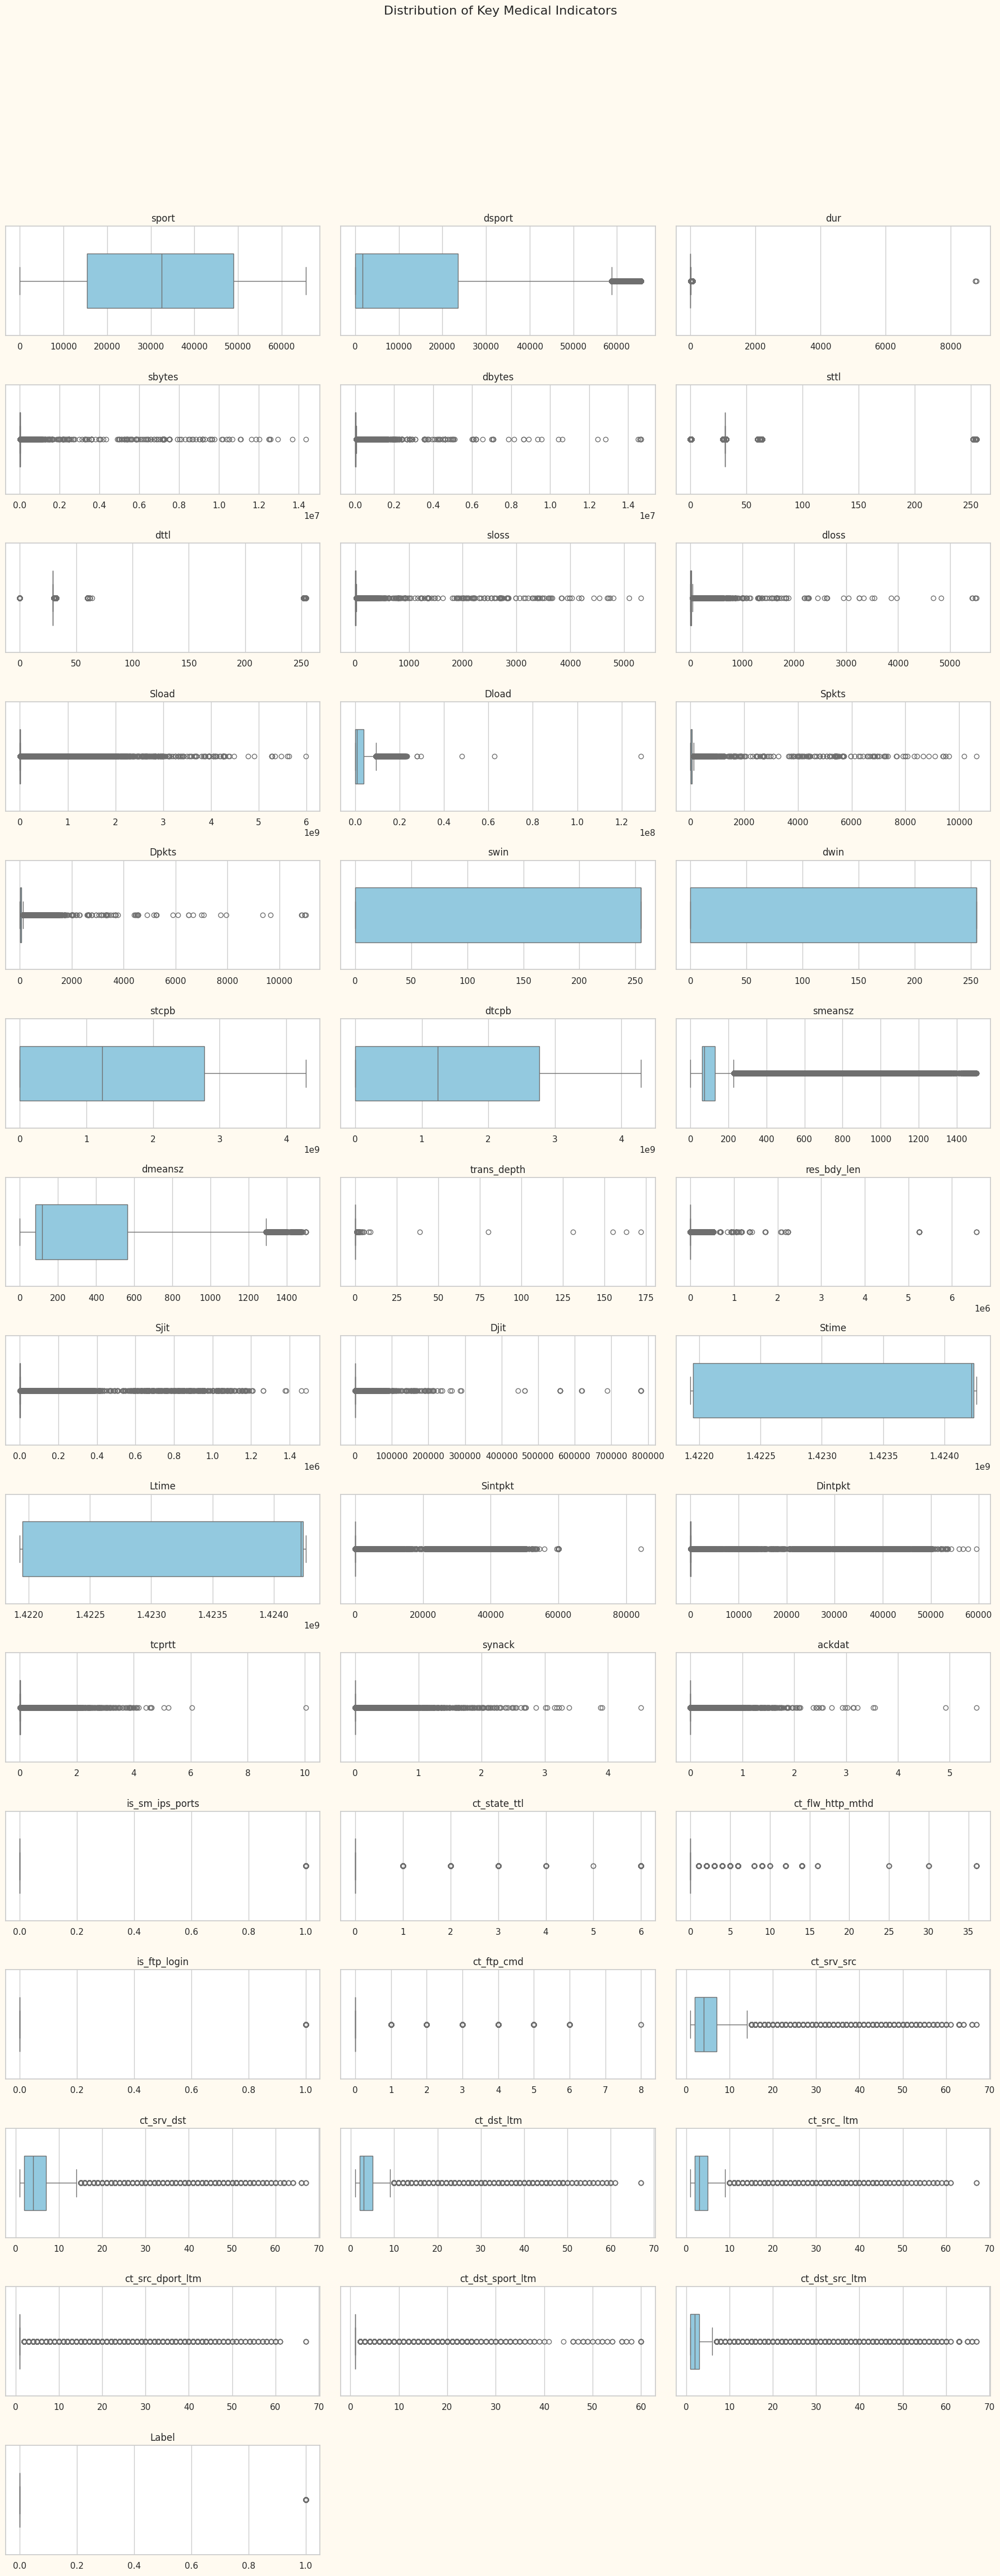

In [38]:
import math

# Number of numerical columns
num_columns = len(numerical_columns)

# Calculate the number of rows and columns needed for the subplots
num_cols = 3  # Fixed number of columns
num_rows = math.ceil(num_columns / num_cols)  # Calculate rows needed

plt.figure(figsize=(18, num_rows * 3))

sns.set_palette("husl")
sns.set(style="whitegrid")

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=train_df[col], color='skyblue', width=0.5)
    plt.title(col)
    plt.xlabel("")

plt.suptitle("Distribution of Key Medical Indicators", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [39]:
# Extract numerical columns
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Columns to exclude
exclude_columns = ['sport', 'swim', 'dwim', 'stcpb', 'dtcpb', 'Stime', 'Ltime']

# Filter out the columns to exclude
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

In [40]:
for col in numerical_columns:
    median_value = train_df[col].median()
    lower_bound = train_df[col].quantile(0.25) - 1.5 * (train_df[col].quantile(0.75) - train_df[col].quantile(0.25))
    upper_bound = train_df[col].quantile(0.75) + 1.5 * (train_df[col].quantile(0.75) - train_df[col].quantile(0.25))
    train_df[col] = train_df[col].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

<a id='3.2'></a>
## **2. Visualising Data Distribution and Skewness**

- |Skewness| < 1: The distribution is approximately symmetric.
- |Skewness| > 1: The distribution is highly skewed.
- |Skewness| between 1 and 2: Moderately skewed distribution.

In [43]:
def transform(X):
    eps = 1e-5
    numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    for col in numerical_columns:
        skewness = skew(X[col])
        if skewness > 0:  # Positive skew
            X[col] = np.log(X[col] + eps)
        elif skewness < 0:  # Negative skew
            X[col] = np.log(np.max(X[col] + eps) - X[col] + eps)
        else:  # Symmetric or zero skew
            X[col] = X[col]  # No transformation needed

    return X

In [44]:
transform(train_df)

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,175.45.176.3,8.969923,149.171.126.15,8.089482,tcp,CON,-1.253983,6.893656,4.454347,31.0,29.0,0.693152,0.000010,-,10.045200,7.094659,1.791761,0.693152,-10.819778,-10.819778,20.451371,22.082540,5.099866,3.761200,0.0,0.0,3.447042,-11.512925,10.537389,10.537415,-0.281908,-6.209621,-6.754176,-6.985717,-8.286081,0.0,0.0,0.0,0.0,0.0,2.302586,2.079443,1.386297,1.609440,1.0,1.0,0.693152,normal,0.0
1,59.166.0.8,10.221323,149.171.126.9,8.836519,tcp,FIN,-1.157341,7.339538,7.404888,31.0,29.0,1.386297,1.386297,-,10.511986,10.584758,2.772589,2.890372,-10.819778,-10.819778,20.414795,21.790466,4.564348,4.510860,0.0,0.0,7.233906,3.558383,9.142062,9.142169,3.040948,2.915594,-6.712188,-6.966444,-8.191493,0.0,0.0,0.0,0.0,0.0,2.639058,1.791761,2.079443,1.098616,1.0,1.0,1.791761,normal,0.0
2,59.166.0.0,10.026767,149.171.126.2,10.559919,udp,CON,-1.200014,6.284134,5.717028,31.0,29.0,-11.512925,-11.512925,-,9.275941,8.708834,1.386297,1.386297,5.541264,5.541264,-11.512925,-11.512925,4.897840,4.330733,0.0,0.0,4.761557,4.816594,14.660415,14.660415,-0.281908,-0.353632,-6.313324,-6.545198,-7.877974,0.0,0.0,0.0,0.0,0.0,2.197226,1.386297,1.945912,1.791761,1.0,1.0,1.098616,normal,0.0
3,175.45.176.1,9.803446,149.171.126.14,3.970292,udp,INT,-10.871072,4.736199,-11.512925,31.0,29.0,-11.512925,-11.512925,dns,13.200695,-11.512925,0.693152,-11.512925,5.541264,5.541264,-11.512925,-11.512925,4.043051,-11.512925,0.0,0.0,-11.512925,-11.512925,9.157572,9.157678,-4.709420,-11.512925,-6.313324,-6.545198,-7.877974,0.0,0.0,0.0,0.0,0.0,1.386297,1.386297,1.098616,1.098616,1.0,1.0,0.693152,generic,0.0
4,59.166.0.5,8.291797,149.171.126.6,3.970292,udp,CON,-6.822495,4.983607,5.181784,31.0,29.0,-11.512925,-11.512925,dns,13.201622,13.399799,0.693152,0.693152,5.541264,5.541264,-11.512925,-11.512925,4.290460,4.488636,0.0,0.0,-11.512925,-11.512925,9.810934,9.810988,-4.709420,-4.960418,-6.313324,-6.545198,-7.877974,0.0,0.0,0.0,0.0,0.0,0.693152,0.693152,1.609440,1.386297,1.0,1.0,0.000010,normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540035,59.166.0.2,10.498057,149.171.126.9,4.962845,tcp,FIN,-3.445776,8.964440,9.619798,31.0,29.0,1.386297,3.465736,-,14.481754,15.137396,2.772589,2.890372,-10.819778,-10.819778,21.073782,21.994746,4.158883,4.787492,0.0,0.0,2.836722,2.681382,10.196120,10.196157,-1.249347,-1.383187,-6.767993,-6.995494,-8.343240,0.0,0.0,0.0,0.0,0.0,1.609440,1.791761,0.000010,1.386297,1.0,1.0,0.000010,normal,0.0
2540037,59.166.0.0,10.761238,149.171.126.0,9.764570,udp,CON,-3.347932,6.269096,5.717028,31.0,29.0,-11.512925,-11.512925,-,11.409072,10.857003,1.386297,1.386297,5.541264,5.541264,-11.512925,-11.512925,4.882802,4.330733,0.0,0.0,2.241743,2.386864,14.650474,14.650475,1.896521,2.041135,-6.313324,-6.545198,-7.877974,0.0,0.0,0.0,0.0,0.0,2.397896,1.386297,1.098616,1.945912,1.0,1.0,0.000010,normal,0.0
2540038,59.166.0.8,10.345606,149.171.126.0,8.554489,tcp,FIN,-4.812317,7.560080,8.369157,31.0,29.0,1.791761,1.791761,-,14.406699,15.219749,3.091043,3.178054,-10.819778,-10.819778,21.463961,22.169542,4.465908,5.192957,0.0,0.0,3.189036,3.047043,14.661593,14.661593,-0.994355,-1.112592,-6.783769,-7.025413,-8.306122,0.0,0.0,0.0,0.0,0.0,1.098616,2.302586,1.386297,0.000010,1.0,1.0,0.000010,normal,0.0
2540039,59.166.0.8,9.125109,149.171.126.2,3.970292,udp,CON,-6.852321,4.867535,5.087596,31.0,29.0,-11.512925,-11.512925,dns,13.115655,13.335717,0.693152,0.693152,5.541264,5.541264,-11.512925,-11.512925,4.174387,4.394449,0.0,

<a id='3.3'></a>
## **3. Visualising Class Distribution**

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def pie_bar_plot(df, col):
    plt.figure(figsize=(10, 6))

    # Extract value counts for the specified column
    value_counts = df[col].value_counts().sort_index()

    ax1 = value_counts
    plt.title(f"Distribution by {col}", fontweight="black", size=14, pad=15)
    colors = sns.color_palette('Set2', len(ax1))
    plt.pie(ax1.values, labels=None, autopct="", startangle=90, colors=colors)
    center_circle = plt.Circle((0, 0), 0.4, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)
    plt.show()

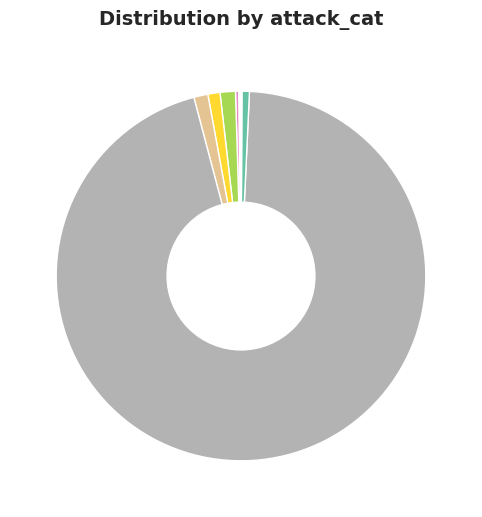

In [46]:
pie_bar_plot(train_df, 'attack_cat')

In [47]:
# Print class distribution before resampling
print("Before resampling:", train_df['attack_cat'].value_counts())
print()

Before resampling: attack_cat
normal            1959771
exploits            27600
generic             25378
fuzzers             21795
reconnaissance      13357
dos                  5665
analysis             2185
backdoor             1684
shellcode            1511
backdoors             300
worms                 171
Name: count, dtype: int64



<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='4'></a>
# 4 | Preprocessing

<div style="padding: 4px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://i.postimg.cc/fTDmwnkQ/Miaka.png); background-size: 100% auto;"></div>


<a id='4.1'></a>
## **1. Featutre Engineering**

In [48]:
def generate_features(df):
    # Duration
    df['duration'] = df['Ltime'] - df['Stime']

    # Ratios
    df['byte_ratio'] = df['sbytes'] / (df['dbytes'] + 1)
    df['pkt_ratio'] = df['Spkts'] / (df['Dpkts'] + 1)
    df['load_ratio'] = df['Sload'] / (df['Dload'] + 1)
    df['jit_ratio'] = df['Sjit'] / (df['Djit'] + 1)
    df['inter_pkt_ratio'] = df['Sintpkt'] / (df['Dintpkt'] + 1)
    df['tcp_setup_ratio'] = df['tcprtt'] / (df['synack'] + df['ackdat'] + 1)

    # Aggregate Features
    df['total_bytes'] = df['sbytes'] + df['dbytes']
    df['total_pkts'] = df['Spkts'] + df['Dpkts']
    df['total_load'] = df['Sload'] + df['Dload']
    df['total_jitter'] = df['Sjit'] + df['Djit']
    df['total_inter_pkt'] = df['Sintpkt'] + df['Dintpkt']
    df['total_tcp_setup'] = df['tcprtt'] + df['synack'] + df['ackdat']

    # Interaction Features
    df['byte_pkt_interaction_src'] = df['sbytes'] * df['Spkts']
    df['byte_pkt_interaction_dst'] = df['dbytes'] * df['Dpkts']
    df['load_jit_interaction_src'] = df['Sload'] * df['Sjit']
    df['load_jit_interaction_dst'] = df['Dload'] * df['Djit']
    df['pkt_jit_interaction_src'] = df['Spkts'] * df['Sjit']
    df['pkt_jit_interaction_dst'] = df['Dpkts'] * df['Djit']

    # Statistical Features
    df['mean_pkt_size'] = df['smeansz'] + df['dmeansz']
    df['tcp_seq_diff'] = df['stcpb'] - df['dtcpb']

    return df

In [49]:
generate_features(train_df)

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label,duration,byte_ratio,pkt_ratio,load_ratio,jit_ratio,inter_pkt_ratio,tcp_setup_ratio,total_bytes,total_pkts,total_load,total_jitter,total_inter_pkt,total_tcp_setup,byte_pkt_interaction_src,byte_pkt_interaction_dst,load_jit_interaction_src,load_jit_interaction_dst,pkt_jit_interaction_src,pkt_jit_interaction_dst,mean_pkt_size,tcp_seq_diff
0,175.45.176.3,8.969923,149.171.126.15,8.089482,tcp,CON,-1.253983,6.893656,4.454347,31.0,29.0,0.693152,0.000010,-,10.045200,7.094659,1.791761,0.693152,-10.819778,-10.819778,20.451371,22.082540,5.099866,3.761200,0.0,0.0,3.447042,-11.512925,10.537389,10.537415,-0.281908,-6.209621,-6.754176,-6.985717,-8.286081,0.0,0.0,0.0,0.0,0.0,2.302586,2.079443,1.386297,1.609440,1.0,1.0,0.693152,normal,0.0,2.652555e-05,1.263883,1.058240,1.240966,-0.327886,0.054113,0.473253,11.348004,2.484913,17.139859,-8.065883,-6.491529,-22.025974,12.351786,3.087541,34.626227,-81.680285,6.176276,-7.980209,8.861067,-1.631169
1,59.166.0.8,10.221323,149.171.126.9,8.836519,tcp,FIN,-1.157341,7.339538,7.404888,31.0,29.0,1.386297,1.386297,-,10.511986,10.584758,2.772589,2.890372,-10.819778,-10.819778,20.414795,21.790466,4.564348,4.510860,0.0,0.0,7.233906,3.558383,9.142062,9.142169,3.040948,2.915594,-6.712188,-6.966444,-8.191493,0.0,0.0,0.0,0.0,0.0,2.639058,1.791761,2.079443,1.098616,1.0,1.0,1.791761,normal,0.0,1.070606e-04,0.873246,0.712680,0.907398,1.586945,0.776625,0.474094,14.744425,5.662962,21.096744,10.792289,5.956542,-21.870126,20.349524,21.402882,76.042718,37.664625,20.056650,10.285052,9.075208,-1.375671
2,59.166.0.0,10.026767,149.171.126.2,10.559919,udp,CON,-1.200014,6.284134,5.717028,31.0,29.0,-11.512925,-11.512925,-,9.275941,8.708834,1.386297,1.386297,5.541264,5.541264,-11.512925,-11.512925,4.897840,4.330733,0.0,0.0,4.761557,4.816594,14.660415,14.660415,-0.281908,-0.353632,-6.313324,-6.545198,-7.877974,0.0,0.0,0.0,0.0,0.0,2.197226,1.386297,1.945912,1.791761,1.0,1.0,1.098616,normal,0.0,0.000000e+00,0.935553,0.580941,0.955412,0.818616,-0.436142,0.470330,12.001162,2.772594,17.984775,9.578151,-0.635541,-20.736496,8.711675,7.925498,44.167925,41.946919,6.600932,6.677229,9.228573,0.000000
3,175.45.176.1,9.803446,149.171.126.14,3.970292,udp,INT,-10.871072,4.736199,-11.512925,31.0,29.0,-11.512925,-11.512925,dns,13.200695,-11.512925,0.693152,-11.512925,5.541264,5.541264,-11.512925,-11.512925,4.043051,-11.512925,0.0,0.0,-11.512925,-11.512925,9.157572,9.157678,-4.709420,-11.512925,-6.313324,-6.545198,-7.877974,0.0,0.0,0.0,0.0,0.0,1.386297,1.386297,1.098616,1.098616,1.0,1.0,0.693152,generic,0.0,1.054130e-04,-0.450512,-0.065933,-1.255663,1.095121,0.447965,0.470330,-6.776727,-10.819773,1.687770,-23.025851,-16.222346,-20.736496,3.282906,132.547453,-151.978620,132.547453,-7.980209,132.547453,-7.469874,0.000000
4,59.166.0.5,8.291797,149.171.126.6,3.970292,udp,CON,-6.822495,4.983607,5.181784,31.0,29.0,-11.512925,-11.512925,dns,13.201622,13.399799,0.693152,0.693152,5.541264,5.541264,-11.512925,-11.512925,4.290460,4.488636,0.0,0.0,-11.512925,-11.512925,9.810934,9.810988,-4.709420,-4.960418,-6.313324,-6.545198,-7.877974,0.0,0.0,0.0,0.0,0.0,0.693152,0.693152,1.609440,1.386297,1.0,1.0,0.000010,normal,0.0,5.484711e-05,0.806176,0.409386,0.916792,1.095121,1.189122,0.470330,10.165390,1.386304,26.601420,-23.025851,-9.669838,-20.736496,3.454398,3.591765,-151.989286,-154.270881,-7.980209,-7.980209,8.779096,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [50]:
# Drop the specified columns from both train_df and test_df
columns_to_drop = ['sport', 'dsport', 'proto','srcip', 'dstip','state', 'service']
train_df.drop(columns=columns_to_drop, inplace=True)

In [51]:
#Checking the categorical columns
cat_columns = train_df.select_dtypes(include=['O']).columns.tolist()
cat_columns

['attack_cat']

<a id='4.2'></a>
## **2. Target feature Encoding**

In [52]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder()

In [53]:
train_df['attack_cat'] = label_encoder.fit_transform(train_df['attack_cat'])

In [54]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)

Label Mapping:
{'analysis': 0, 'backdoor': 1, 'backdoors': 2, 'dos': 3, 'exploits': 4, 'fuzzers': 5, 'generic': 6, 'normal': 7, 'reconnaissance': 8, 'shellcode': 9, 'worms': 10}


<a id='4.3'></a>
## **3. checking Highly Correlated Features**

<Axes: title={'center': 'Correlation Plot'}, xlabel='Name', ylabel='Name'>

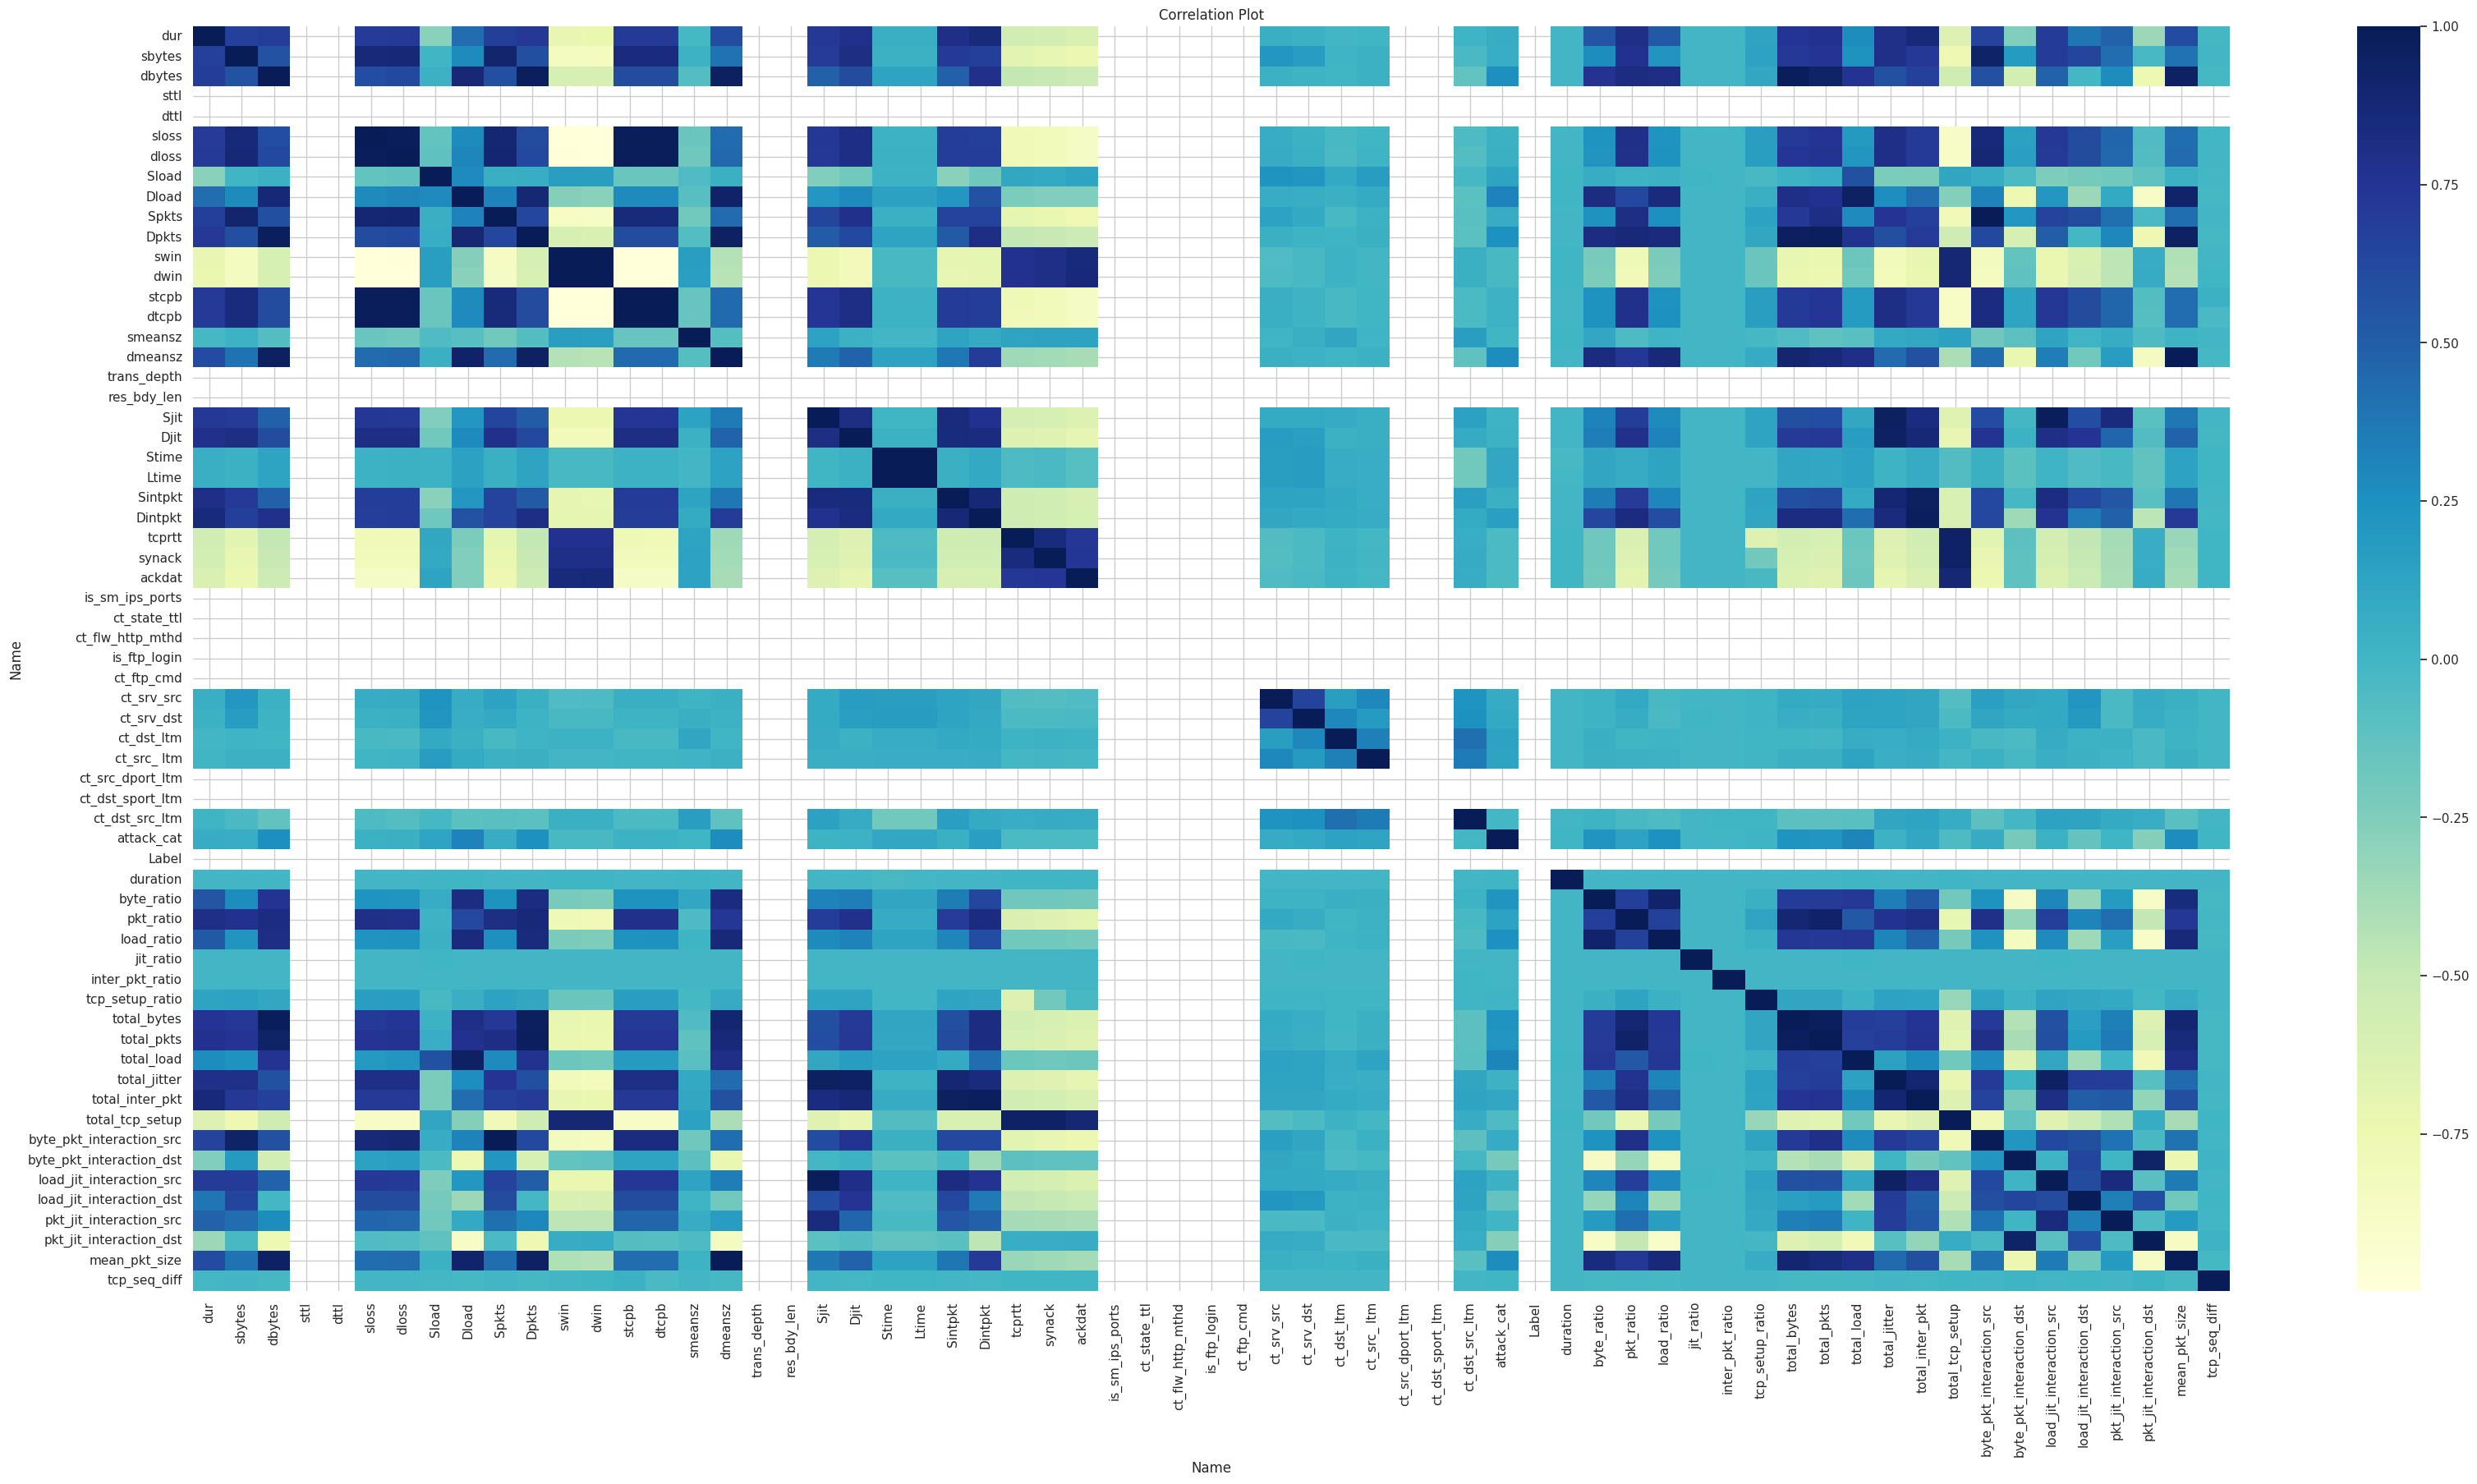

In [55]:
plt.figure(figsize=(40,20))
plt.title("Correlation Plot")
sns.heatmap(train_df.corr(),cmap='YlGnBu')

In [56]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask = correlation_matrix >= 0.75

# Identify and list the highly correlated features
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))

# Print the highly correlated features
print("Highly correlated features:")
for feature1, feature2 in highly_correlated_features:
    print(f"{feature1} and {feature2}")


Highly correlated features:
dur and Djit
dur and Sintpkt
dur and Dintpkt
dur and pkt_ratio
dur and total_pkts
dur and total_jitter
dur and total_inter_pkt
sbytes and sloss
sbytes and dloss
sbytes and Spkts
sbytes and stcpb
sbytes and dtcpb
sbytes and Djit
sbytes and pkt_ratio
sbytes and total_jitter
sbytes and byte_pkt_interaction_src
dbytes and Dload
dbytes and Dpkts
dbytes and dmeansz
dbytes and Dintpkt
dbytes and byte_ratio
dbytes and pkt_ratio
dbytes and load_ratio
dbytes and total_bytes
dbytes and total_pkts
dbytes and total_load
dbytes and mean_pkt_size
sloss and dloss
sloss and Spkts
sloss and stcpb
sloss and dtcpb
sloss and Djit
sloss and pkt_ratio
sloss and total_jitter
sloss and byte_pkt_interaction_src
dloss and Spkts
dloss and stcpb
dloss and dtcpb
dloss and Djit
dloss and pkt_ratio
dloss and total_pkts
dloss and total_jitter
dloss and byte_pkt_interaction_src
Dload and Dpkts
Dload and dmeansz
Dload and byte_ratio
Dload and load_ratio
Dload and total_bytes
Dload and total_p

In [57]:
# Create a set of features to drop
features_to_drop = set()

# Iterate over the highly correlated features and add one of each pair to the drop list
for feature1, feature2 in highly_correlated_features:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        features_to_drop.add(feature2)  # You can choose feature1 or feature2 to drop

# Drop the features from the DataFrame
train_df = train_df.drop(columns=features_to_drop)

# Print the remaining features
print("Remaining features after dropping highly correlated ones:")
print(train_df.columns)

Remaining features after dropping highly correlated ones:
Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'Sload', 'swin', 'smeansz',
       'trans_depth', 'res_bdy_len', 'Sjit', 'Stime', 'is_sm_ips_ports',
       'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd',
       'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'Label', 'duration', 'jit_ratio', 'inter_pkt_ratio', 'tcp_setup_ratio',
       'byte_pkt_interaction_dst', 'load_jit_interaction_dst', 'tcp_seq_diff'],
      dtype='object', name='Name')


<a id='4.4'></a>
## **4. Splitting the features in dependent and independent features**


In [58]:
x = train_df.drop(['attack_cat'], axis=1)
y = train_df[['attack_cat']]

<a id='4.5'></a>
## **5. Applying SMOTE to balance the unbalanced data**



In [59]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pandas as pd

# Define the desired number of samples for each class
desired_count = 15000

# Define the oversampling strategy for SMOTE
oversample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] < desired_count}

# Define the undersampling strategy for RandomUnderSampler
undersample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] > desired_count}

# Create the SMOTE and RandomUnderSampler objects
smote = SMOTE(sampling_strategy=oversample_strategy)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)

# Combine SMOTE and RandomUnderSampler in a pipeline
pipeline = Pipeline(steps=[('smote', smote), ('undersample', undersample)])

# Print class distribution before resampling
print("Before resampling:", y.value_counts())
print()

# Apply the pipeline to resample the dataset
x_resampled, y_resampled = pipeline.fit_resample(x, y)

# Print class distribution after resampling
print("After resampling:", y_resampled.value_counts())

Before resampling: attack_cat
7             1959771
4               27600
6               25378
5               21795
8               13357
3                5665
0                2185
1                1684
9                1511
2                 300
10                171
Name: count, dtype: int64

After resampling: attack_cat
0             15000
1             15000
2             15000
3             15000
4             15000
5             15000
6             15000
7             15000
8             15000
9             15000
10            15000
Name: count, dtype: int64


In [60]:
x = x_resampled
y = y_resampled

<a id='4.6'></a>
## **6. Checking Feature Importance**


In [61]:
discrete_features = x.dtypes == int

def mi_score_maker(x,y,discrete_features):
    scores = mutual_info_regression(x,y,discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features':x.columns,
        'Scores':scores
    })
    df = df.sort_values(['Scores'],ascending=False).reset_index(drop=True)
    return df

In [62]:
mi_scores = mi_score_maker(x,y.astype('float64'),discrete_features)

mi_scores

,Features,Scores
0,sbytes,1.309544
1,smeansz,1.062457
2,byte_pkt_interaction_dst,0.758884
3,dbytes,0.735814
4,duration,0.675035
5,Stime,0.599858
6,inter_pkt_ratio,0.565640
7,dur,0.515626
8,ct_srv_dst,0.479360
9,load_jit_interaction_dst,0.473287


In [63]:
# Filter features with scores less than 0.001285
low_score_features = mi_scores[mi_scores['Scores'] < 0.01]

# Extract the feature names
low_score_feature_names = low_score_features['Features'].tolist()

# Print the list of low score feature names
low_score_feature_names

['sttl',
 'ct_state_ttl',
 'ct_ftp_cmd',
 'res_bdy_len',
 'ct_src_dport_ltm',
 'is_sm_ips_ports',
 'is_ftp_login',
 'ct_flw_http_mthd',
 'ct_dst_sport_ltm',
 'Label',
 'trans_depth',
 'dttl']

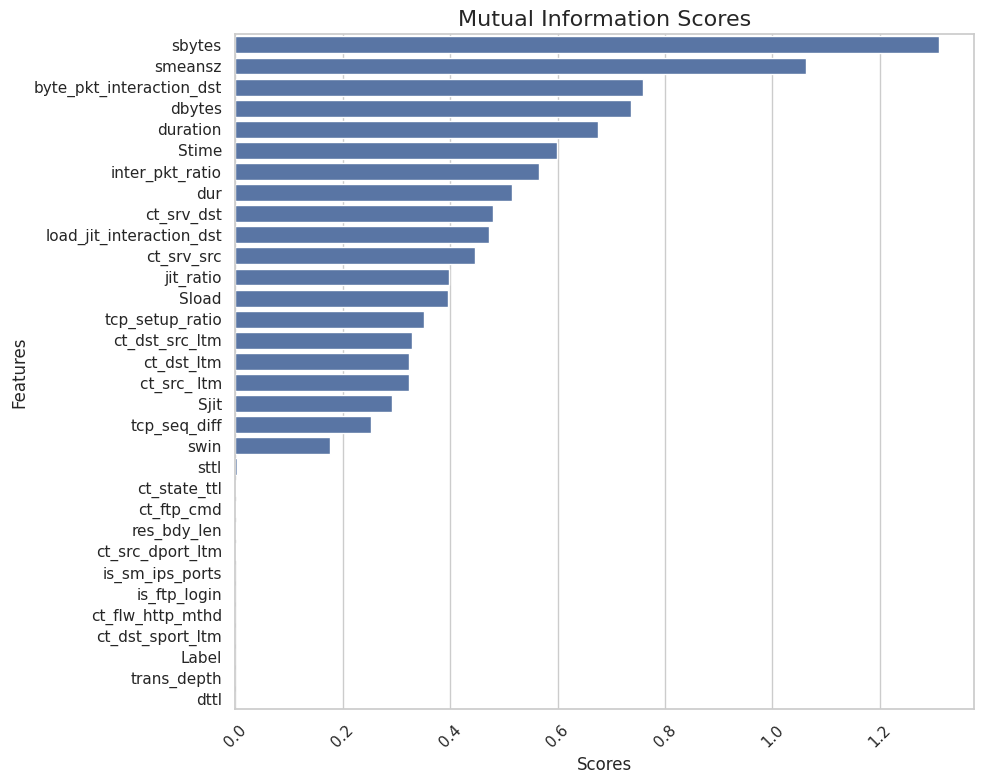

In [64]:
plt.figure(figsize=(10, 8))

# Create the barplot
sns.barplot(x='Scores', y='Features', data=mi_scores)

# Add a title
plt.title("Mutual Information Scores", fontsize=16)

# Rotate the y-axis labels (if needed)
plt.yticks(rotation=0)

# Rotate the x-axis labels (if needed)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
plt.show()

In [65]:
x.drop(low_score_feature_names,axis=1, inplace = True)

<center><div style='color:#ffffff;
           display:inline-block;
           padding: 5px 5px 5px 5px;
           border-radius:5px;
           background-color:#78D1E1;
           font-size:100%;'><a href=#toc style='text-decoration: none; color:#03001C;'>⬆️ Back To Top</a></div></center>

<a id='4.7'></a>
## **7.Feature Scaling**


In [66]:
scaler = StandardScaler()

In [67]:
x_scaled = scaler.fit_transform(x)

<a id='4.8'></a>
## **8. Checking Variance captured by features**

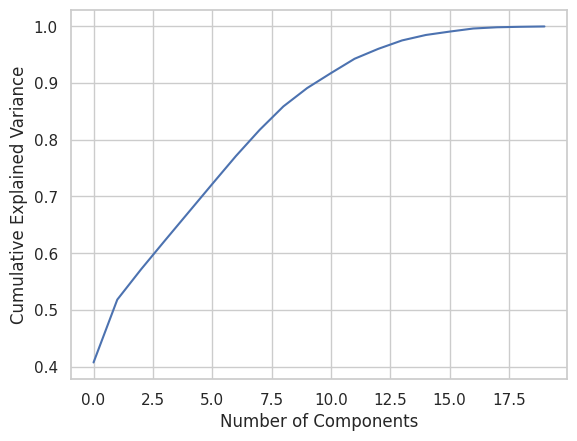

In [68]:
pca = PCA()
pca.fit(x_scaled)  # X_train is your training data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
